In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
! which jupyter

/home/abaumann/anaconda3/envs/cuda/bin/jupyter


In [7]:
import logging
import random
from functools import partial
from pathlib import Path
import pandas as pd
import numpy as np

import fire
import torch
from fastai.basic_data import DataBunch
from fastai.basic_train import Learner
from fastai.metrics import fbeta
from fastai.train import to_fp16
from learner import (OneHotCallBack, conll_f1, create_fp16_cb,
                     ner_loss_func, Conll_F1)
from ner_data import NerDataset, pad
from optimizer import BertAdam
from pytorch_pretrained_bert import BertForTokenClassification
from torch.utils.data import DataLoader
from fastai.torch_core import flatten_model

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


# Initialisation

Define Values for the Run

In [8]:
lang='deu'
ds_size=None
name = 'jpdi'
datapath = 'data/conll-2003-I/'
csvn = 'logs/eng-tune'+name+'.csv'
pretrain=False
pretrained_lm = 'pretrain/pytorch_fastai_model_bert-base-multilingual-cased_10.bin'

In [9]:
log_dir:str='logs'
batch_size:int=16
lr:float=5e-5
epochs:int=1
trainset:str=datapath
devset:str=datapath
testset:str=datapath
max_seq_len:int=128
do_lower_case:bool=False
warmup_proportion:float=0.1
data_bunch_path:str='data/conll-2003/db'

In [10]:
bert_model = 'bert-base-cased' if lang=='eng' else 'bert-base-multilingual-cased'

## Dataset
Load the dataset and define a databunch

In [11]:
trainset += lang + '/train.txt'
devset += lang + '/dev.txt'
testset += lang + '/test.txt'

In [13]:
train_dl = DataLoader(
    dataset=NerDataset(trainset, bert_model, max_seq_len=max_seq_len, ds_size=ds_size),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=pad
)

dev_dl = DataLoader(
    dataset=NerDataset(devset, bert_model, max_seq_len=max_seq_len, ds_size=ds_size),
    batch_size=batch_size,
    shuffle=False,
    collate_fn=pad
)

test_dl = DataLoader(
    dataset=NerDataset(testset, bert_model, max_seq_len=max_seq_len, ds_size=ds_size),
    batch_size=batch_size,
    shuffle=False,
    collate_fn=pad
)

data = DataBunch(
    train_dl= train_dl,
    valid_dl= dev_dl,
    test_dl = test_dl,
    collate_fn=pad,
    path = Path(data_bunch_path)
)


data/conll-2003/deu/train.txt
lines 12705 sents 12152	style: x=s y=s

data/conll-2003/deu/dev.txt
lines 3068 sents 2867	style: x=s y=s

data/conll-2003/deu/test.txt
lines 3160 sents 3005	style: x=s y=s


## Model & Learner
define BERT model
define Learner object

In [15]:
num_layers = 15

In [16]:
def bert_layer_list(model):
    ms = torch.nn.ModuleList()

    flm = flatten_model(model)
    # embedding = [0:5] layer
    ms.append(torch.nn.ModuleList(flm[0:5]))
    # encoder (12 layers) = [5:16] [16:27] ... [126:136]
    for i in range(5, 137, 11):
        ms.append(torch.nn.ModuleList(flm[i: i+11]))
    # pooling layer = [137:139]
    ms.append(torch.nn.ModuleList(flm[-4:-2]))
    # head = [-2:]
    ms.append(torch.nn.ModuleList(flm[-2:]))
    return ms

In [17]:

model = BertForTokenClassification.from_pretrained(bert_model, num_labels=10, cache_dir='bertm')
if pretrain:
    model.bert.load_state_dict(torch.load(pretrained_lm))

model = torch.nn.DataParallel(model)
optim = BertAdam
loss_fun = ner_loss_func

In [18]:
metrics = [Conll_F1()]

In [19]:
learn = Learner(data, model, optim,
                    loss_func=loss_fun,
                    metrics=metrics,
                    true_wd=False,
                    layer_groups= bert_layer_list(model),
                    path='learn-deu',
                    )

In [20]:
batch_size

16

In [21]:
lang

'deu'

In [22]:
def test_lrs(stage, all_lrs, runs=1):
    res = []
    for i,lrs in enumerate(all_lrs):
        lrs,lrm = lrs
        print(i, lrm, lrs)
        i_res = {'lrs': lrs, 'lrm':lrm, 'f1s':[], 'vals':[], 'train':[]}
        for _ in range(runs):
            learn.load(stage)
            learn.fit_one_cycle(1, lrs, moms=(0.8,0.7))
            
            i_res['f1s'].append(learn.recorder.metrics[0][0])
            i_res['vals'].append(learn.recorder.val_losses[0])
            i_res['train'].append(learn.recorder.losses)
        i_res['val'] = sum(i_res['vals'])/runs
        i_res['f1'] = sum(i_res['f1s'])/runs
        res.append(i_res)
    return res

In [21]:
chtw = ([2e-5]*14+[3e-4], 0)
chtw2 = ([2e-5]*2 +[3e-5]*3+[1e-4]*3+[3e-4]*3+[8e-4]*3 +[8e-3], 0)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


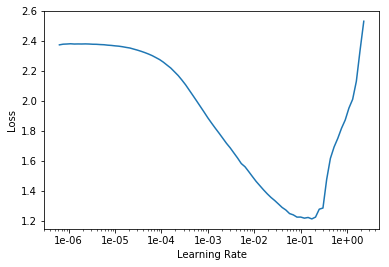

In [22]:
learn.freeze()
learn.save(name+'x')
learn.lr_find()
learn.recorder.plot()

In [23]:
lrs = [
    1e-02, 5e-2, 8e-3, 5e-3,
]
lrs = [(i, 1) for i in lrs]
stage1 = test_lrs('x', lrs, runs=1)

0 1 0.01


epoch,train_loss,valid_loss,Total F1,time
0,0.172080,0.157025,0.738771,04:45


1 1 0.05


epoch,train_loss,valid_loss,Total F1,time
0,0.387418,0.321667,0.733258,04:45


2 1 0.008


epoch,train_loss,valid_loss,Total F1,time
0,0.174680,0.149283,0.748962,04:45


3 1 0.005


epoch,train_loss,valid_loss,Total F1,time
0,0.170635,0.148952,0.736877,04:45


In [24]:
df = pd.DataFrame(stage1).sort_values(by=['f1', 'val'],ascending=[False, True])
df.to_csv(csvn, mode='a')
df

,f1,f1s,lrm,lrs,train,val,vals
2,0.748962,[0.7489618104299826],1,0.008,"[[tensor(2.3993), tensor(2.1746), tensor(1.965...",0.149283,[0.14928262]
0,0.738771,[0.738771168610339],1,0.010,"[[tensor(2.3470), tensor(2.1388), tensor(1.885...",0.157025,[0.15702549]
3,0.736877,[0.7368768021405584],1,0.005,"[[tensor(2.4337), tensor(2.2747), tensor(2.110...",0.148952,[0.14895162]
1,0.733258,[0.7332576612502248],1,0.050,"[[tensor(2.3987), tensor(1.6597), tensor(1.421...",0.321667,[0.32166737]


In [21]:
learn.load(name+'x')
lr0 =  df.iloc[0]['lrs']
learn.fit_one_cycle(1, df.iloc[0]['lrs'], moms=(0.8,0.7))

epoch,train_loss,valid_loss,Total F1,time
0,0.125057,0.152426,0.739395,03:27


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


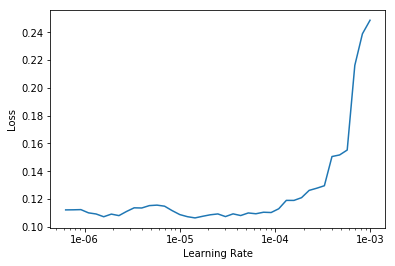

In [22]:
learn.freeze_to(-3)
learn.save(name+'x3')
learn.lr_find()
learn.recorder.plot()

In [23]:
lrs =[]
lrms = [2.6, 1.6, 1] 
lrs.append(chtw)
lrs.append(chtw2)
for lrm in lrms:
    div = (lrm**num_layers)
    lrs.append((learn.lr_range(slice(2e-4/div, 2e-4)),lrm))
    lrs.append((learn.lr_range(slice(3e-4/div, 3e-4)),lrm))
    lrs.append((learn.lr_range(slice(5e-4/div, 5e-4)),lrm))
    if lrm!=1: lrs.append((learn.lr_range(slice(lr0/div, lr0)),lrm))
stage2 = test_lrs(name+'x3', lrs)

0 [5.962107e-10 1.659641e-09 4.619855e-09 1.286005e-08 3.579785e-08 9.964862e-08 2.773867e-07 7.721468e-07 2.149385e-06
 5.983131e-06 1.665493e-05 4.636146e-05 1.290540e-04 3.592408e-04 1.000000e-03] 2.6


epoch,train_loss,valid_loss,Total F1,time
0,0.094890,0.120441,0.798575,03:39


epoch,train_loss,valid_loss,Total F1,time
0,0.095008,0.116394,0.809201,03:39


1 [1.192421e-09 3.319281e-09 9.239711e-09 2.572010e-08 7.159571e-08 1.992972e-07 5.547733e-07 1.544294e-06 4.298770e-06
 1.196626e-05 3.330986e-05 9.272292e-05 2.581080e-04 7.184817e-04 2.000000e-03] 2.6


epoch,train_loss,valid_loss,Total F1,time
0,0.093602,0.117095,0.804610,03:39


epoch,train_loss,valid_loss,Total F1,time
0,0.096187,0.114914,0.813605,03:39


2 [5.962107e-11 1.659641e-10 4.619855e-10 1.286005e-09 3.579785e-09 9.964862e-09 2.773867e-08 7.721468e-08 2.149385e-07
 5.983131e-07 1.665493e-06 4.636146e-06 1.290540e-05 3.592408e-05 1.000000e-04] 2.6


epoch,train_loss,valid_loss,Total F1,time
0,0.108177,0.135331,0.769389,03:39


epoch,train_loss,valid_loss,Total F1,time
0,0.107568,0.137109,0.766916,03:39


3 [1.192421e-10 3.319281e-10 9.239711e-10 2.572010e-09 7.159571e-09 1.992972e-08 5.547733e-08 1.544294e-07 4.298770e-07
 1.196626e-06 3.330986e-06 9.272292e-06 2.581080e-05 7.184817e-05 2.000000e-04] 2.6


epoch,train_loss,valid_loss,Total F1,time
0,0.105804,0.127383,0.786014,03:38


epoch,train_loss,valid_loss,Total F1,time
0,0.107155,0.131633,0.778287,03:38


4 [2.981054e-10 8.298204e-10 2.309928e-09 6.430025e-09 1.789893e-08 4.982431e-08 1.386933e-07 3.860734e-07 1.074692e-06
 2.991565e-06 8.327465e-06 2.318073e-05 6.452699e-05 1.796204e-04 5.000000e-04] 2.6


epoch,train_loss,valid_loss,Total F1,time
0,0.097596,0.122939,0.797225,03:39


epoch,train_loss,valid_loss,Total F1,time
0,0.121437,0.124558,0.793246,03:39


5 [8.673617e-07 1.435160e-06 2.374653e-06 3.929164e-06 6.501300e-06 1.075722e-05 1.779919e-05 2.945101e-05 4.873042e-05
 8.063064e-05 1.334136e-04 2.207497e-04 3.652583e-04 6.043660e-04 1.000000e-03] 1.6


epoch,train_loss,valid_loss,Total F1,time
0,0.093850,0.118082,0.796257,03:39


epoch,train_loss,valid_loss,Total F1,time
0,0.096395,0.118014,0.806598,03:38


6 [1.734723e-06 2.870319e-06 4.749307e-06 7.858329e-06 1.300260e-05 2.151445e-05 3.559837e-05 5.890201e-05 9.746083e-05
 1.612613e-04 2.668272e-04 4.414993e-04 7.305165e-04 1.208732e-03 2.000000e-03] 1.6


epoch,train_loss,valid_loss,Total F1,time
0,0.101367,0.125730,0.790705,03:39


epoch,train_loss,valid_loss,Total F1,time
0,0.114202,0.127216,0.782801,03:39


7 [8.673617e-08 1.435160e-07 2.374653e-07 3.929164e-07 6.501300e-07 1.075722e-06 1.779919e-06 2.945101e-06 4.873042e-06
 8.063064e-06 1.334136e-05 2.207497e-05 3.652583e-05 6.043660e-05 1.000000e-04] 1.6


epoch,train_loss,valid_loss,Total F1,time
0,0.097588,0.127569,0.787377,03:39


epoch,train_loss,valid_loss,Total F1,time
0,0.100055,0.128171,0.781109,03:38


8 [1.734723e-07 2.870319e-07 4.749307e-07 7.858329e-07 1.300260e-06 2.151445e-06 3.559837e-06 5.890201e-06 9.746083e-06
 1.612613e-05 2.668272e-05 4.414993e-05 7.305165e-05 1.208732e-04 2.000000e-04] 1.6


epoch,train_loss,valid_loss,Total F1,time
0,0.099325,0.120831,0.799247,03:39


epoch,train_loss,valid_loss,Total F1,time
0,0.096942,0.123981,0.798983,03:39


9 [4.336809e-07 7.175799e-07 1.187327e-06 1.964582e-06 3.250650e-06 5.378611e-06 8.899593e-06 1.472550e-05 2.436521e-05
 4.031532e-05 6.670680e-05 1.103748e-04 1.826291e-04 3.021830e-04 5.000000e-04] 1.6


epoch,train_loss,valid_loss,Total F1,time
0,0.098907,0.117975,0.801689,03:39


epoch,train_loss,valid_loss,Total F1,time
0,0.094956,0.117637,0.806639,03:39


10 [1.953663e-05 2.587807e-05 3.427789e-05 4.540422e-05 6.014207e-05 7.966371e-05 1.055219e-04 1.397735e-04 1.851429e-04
 2.452388e-04 3.248414e-04 4.302823e-04 5.699486e-04 7.549494e-04 1.000000e-03] 1.3


epoch,train_loss,valid_loss,Total F1,time
0,0.098440,0.122465,0.794292,03:39


epoch,train_loss,valid_loss,Total F1,time
0,0.141925,0.117515,0.813755,03:39


11 [3.907327e-05 5.175614e-05 6.855577e-05 9.080844e-05 1.202841e-04 1.593274e-04 2.110438e-04 2.795470e-04 3.702858e-04
 4.904776e-04 6.496828e-04 8.605647e-04 1.139897e-03 1.509899e-03 2.000000e-03] 1.3


epoch,train_loss,valid_loss,Total F1,time
0,0.111651,0.135022,0.769487,03:39


epoch,train_loss,valid_loss,Total F1,time
0,0.110607,0.138044,0.758664,03:39


12 [1.953663e-06 2.587807e-06 3.427789e-06 4.540422e-06 6.014207e-06 7.966371e-06 1.055219e-05 1.397735e-05 1.851429e-05
 2.452388e-05 3.248414e-05 4.302823e-05 5.699486e-05 7.549494e-05 1.000000e-04] 1.3


epoch,train_loss,valid_loss,Total F1,time
0,0.095270,0.123141,0.789980,03:39


epoch,train_loss,valid_loss,Total F1,time
0,0.098660,0.123300,0.788013,03:39


13 [3.907327e-06 5.175614e-06 6.855577e-06 9.080844e-06 1.202841e-05 1.593274e-05 2.110438e-05 2.795470e-05 3.702858e-05
 4.904776e-05 6.496828e-05 8.605647e-05 1.139897e-04 1.509899e-04 2.000000e-04] 1.3


epoch,train_loss,valid_loss,Total F1,time
0,0.093575,0.119613,0.807056,03:39


epoch,train_loss,valid_loss,Total F1,time
0,0.094651,0.118149,0.800811,03:39


14 [9.768316e-06 1.293903e-05 1.713894e-05 2.270211e-05 3.007103e-05 3.983186e-05 5.276096e-05 6.988675e-05 9.257144e-05
 1.226194e-04 1.624207e-04 2.151412e-04 2.849743e-04 3.774747e-04 5.000000e-04] 1.3


epoch,train_loss,valid_loss,Total F1,time
0,0.099335,0.119621,0.803760,03:39


epoch,train_loss,valid_loss,Total F1,time
0,0.099146,0.114814,0.816974,03:39


15 [0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001] 1


epoch,train_loss,valid_loss,Total F1,time
0,0.107554,0.128627,0.782588,03:39


epoch,train_loss,valid_loss,Total F1,time
0,0.114527,0.128082,0.782561,03:39


16 [0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002 0.002] 1


epoch,train_loss,valid_loss,Total F1,time
0,0.200636,0.255318,0.336230,03:39


epoch,train_loss,valid_loss,Total F1,time
0,0.178934,0.223043,0.479615,03:39


17 [0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001] 1


epoch,train_loss,valid_loss,Total F1,time
0,0.088464,0.116918,0.812021,03:39


epoch,train_loss,valid_loss,Total F1,time
0,0.094340,0.121060,0.797229,03:39


18 [0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002 0.0002] 1


epoch,train_loss,valid_loss,Total F1,time
0,0.099032,0.117542,0.802224,03:39


epoch,train_loss,valid_loss,Total F1,time
0,0.095719,0.116951,0.809494,03:38


19 [0.0005 0.0005 0.0005 0.0005 0.0005 0.0005 0.0005 0.0005 0.0005 0.0005 0.0005 0.0005 0.0005 0.0005 0.0005] 1


epoch,train_loss,valid_loss,Total F1,time
0,0.102039,0.126931,0.786772,03:39


epoch,train_loss,valid_loss,Total F1,time
0,0.102238,0.124483,0.797822,03:38


In [24]:
df = pd.DataFrame(stage2).sort_values(by=['f1', 'val'],ascending=[False, True])
df.to_csv(csvn, mode='a')
df

,f1,f1s,lrm,lrs,train,val,vals
14,0.810367,"[0.8037602815215439, 0.8169744592254504]",1.3,"[9.768316435592065e-06, 1.2939034859632092e-05...","[[tensor(0.1145), tensor(0.1367), tensor(0.162...",0.117217,"[0.11962091, 0.11481395]"
1,0.809107,"[0.8046104044900226, 0.813604586728509]",2.6,"[1.1924214398916095e-09, 3.3192814395810177e-0...","[[tensor(0.0544), tensor(0.0852), tensor(0.098...",0.116004,"[0.11709512, 0.11491382]"
18,0.805859,"[0.8022236136563409, 0.8094939678538278]",1.0,"[0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.000...","[[tensor(0.1490), tensor(0.1283), tensor(0.117...",0.117247,"[0.117542274, 0.11695079]"
17,0.804625,"[0.8120206600106099, 0.7972292186441414]",1.0,"[0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.000...","[[tensor(0.1118), tensor(0.1118), tensor(0.140...",0.118989,"[0.116918474, 0.12106043]"
9,0.804164,"[0.8016890830161307, 0.8066393953469835]",1.6,"[4.336808689942014e-07, 7.175798680306995e-07,...","[[tensor(0.1447), tensor(0.1157), tensor(0.122...",0.117806,"[0.11797511, 0.117637165]"
10,0.804023,"[0.7942915708954106, 0.8137553726929695]",1.3,"[1.953663287118413e-05, 2.5878069719264184e-05...","[[tensor(0.1189), tensor(0.1651), tensor(0.147...",0.119990,"[0.12246543, 0.11751535]"
13,0.803934,"[0.8070564032662928, 0.8008114218299857]",1.3,"[3.907326574236826e-06, 5.175613943852837e-06,...","[[tensor(0.1813), tensor(0.1809), tensor(0.156...",0.118881,"[0.119612776, 0.11814946]"
0,0.803888,"[0.7985753853337937, 0.8092011969166953]",2.6,"[5.962107199458047e-10, 1.6596407197905088e-09...","[[tensor(0.1196), tensor(0.1198), tensor(0.126...",0.118417,"[0.120440625, 0.11639374]"
5,0.801427,"[0.7962569783477383, 0.8065978731713688]",1.6,"[8.673617379884028e-07, 1.435159736061399e-06,...","[[tensor(0.0819), tensor(0.0972), tensor(0.125...",0.118048,"[0.11808194, 0.118013784]"
8,0.799115,"[0.7992465855936894, 0.7989834003428236]",1.6,"[1.7347234759768058e-07, 2.870319472122798e-07...","[[tensor(0.0752), tensor(0.1009), tensor(0.123...",0.122406,"[0.12083129, 0.12398051]"


In [25]:
learn.load(name+'x3')
learn.fit_one_cycle(1,df.iloc[0]['lrs'], moms=(0.8,0.7))

epoch,train_loss,valid_loss,Total F1,time
0,0.075342,0.115575,0.816224,03:39


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


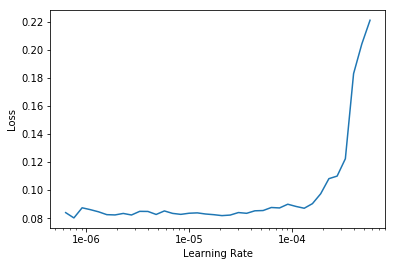

In [26]:
learn.freeze_to(-6)
learn.save(name+'x6')
learn.lr_find()
learn.recorder.plot()


In [28]:
lrs =[]
lrms = [2.6, 1.6, 1] # 2.6,
lrs.append(chtw)
lrs.append(chtw2)
for lrm in lrms:
    div = (lrm**num_layers)
    lrs.append((learn.lr_range(slice(5e-4/div, 5e-4)),lrm))
    if lrm!= 1: lrs.append((learn.lr_range(slice(lr0/div, lr0)),lrm))
    lrs.append((learn.lr_range(slice(3e-4/div, 3e-4)),lrm))
    lrs.append((learn.lr_range(slice(1e-4/div, 1e-4)),lrm))
stage3 = test_lrs(name+'x6', lrs)

0 [2.981054e-10 8.298204e-10 2.309928e-09 6.430025e-09 1.789893e-08 4.982431e-08 1.386933e-07 3.860734e-07 1.074692e-06
 2.991565e-06 8.327465e-06 2.318073e-05 6.452699e-05 1.796204e-04 5.000000e-04] 2.6


epoch,train_loss,valid_loss,Total F1,time
0,0.070174,0.105957,0.827506,04:16


epoch,train_loss,valid_loss,Total F1,time
0,0.098680,0.104968,0.835117,04:16


1 [5.962107e-11 1.659641e-10 4.619855e-10 1.286005e-09 3.579785e-09 9.964862e-09 2.773867e-08 7.721468e-08 2.149385e-07
 5.983131e-07 1.665493e-06 4.636146e-06 1.290540e-05 3.592408e-05 1.000000e-04] 2.6


epoch,train_loss,valid_loss,Total F1,time
0,0.071920,0.113687,0.823612,04:16


epoch,train_loss,valid_loss,Total F1,time
0,0.075945,0.113097,0.825248,04:15


2 [2.981054e-11 8.298204e-11 2.309928e-10 6.430025e-10 1.789893e-09 4.982431e-09 1.386933e-08 3.860734e-08 1.074692e-07
 2.991565e-07 8.327465e-07 2.318073e-06 6.452699e-06 1.796204e-05 5.000000e-05] 2.6


epoch,train_loss,valid_loss,Total F1,time
0,0.070942,0.114204,0.819196,04:15


epoch,train_loss,valid_loss,Total F1,time
0,0.068828,0.113827,0.824478,04:15


3 [7.750739e-11 2.015192e-10 5.239500e-10 1.362270e-09 3.541902e-09 9.208945e-09 2.394326e-08 6.225247e-08 1.618564e-07
 4.208267e-07 1.094149e-06 2.844788e-06 7.396450e-06 1.923077e-05 5.000000e-05 1.000000e-05] 2.6


AssertionError: List len mismatch (16 vs 15)

In [ ]:
df = pd.DataFrame(stage3).sort_values(by=['f1', 'val'],ascending=[False, True])
df.to_csv(csvn, mode='a')
df

In [23]:
learn.load(name+'x6')    
learn.fit_one_cycle(1, df.iloc[0]['lrs'], moms=(0.8, 0.7))

epoch,train_loss,valid_loss,Total F1,time
0,0.042702,0.074312,0.855313,08:51


In [25]:
learn.freeze_to(-12)
learn.save(name+'x12')
learn.lr_find()
learn.recorder.plot()

In [ ]:
lrs =[]
lrms = [2.6, 1.6, 1] # 2.6,
lrs.append(chtw)
lrs.append(chtw2)
for lrm in lrms:
    div = (lrm**num_layers)
    if lrm!= 1: lrs.append((learn.lr_range(slice(lr0/div, lr0)),lrm))
    lrs.append((learn.lr_range(slice(3e-4/div, 3e-4)),lrm))
    lrs.append((learn.lr_range(slice(1e-4/div, 1e-4)),lrm))
    lrs.append((learn.lr_range(slice(5e-5/div, 5e-5)),lrm))

In [ ]:
stage12 = test_lrs(name+'x12', lrs)

In [ ]:
df = pd.DataFrame(stage12).sort_values(by=['f1', 'val'],ascending=[False, True])
df.to_csv(csvn, mode='a')
df

In [ ]:
learn.load(name+'x12')
learn.fit_one_cycle(1, df.iloc[0]['lrs'], moms=(0.8, 0.7))
learn.recorder.plot_losses()

In [ ]:
learn.unfreeze()
learn.save(name+'x15')
learn.lr_find()
learn.recorder.plot()

In [ ]:
lrs =[]
lrms = [2.6, 1.6, 1]#2.6, 
lrs.append(chtw)
lrs.append(chtw2)
for lrm in lrms:
    div = (lrm**num_layers)
    if lrm!= 1: lrs.append((learn.lr_range(slice(lr0/div, lr0)),lrm))
    lrs.append((learn.lr_range(slice(2e-5/div, 2e-5)),lrm))
    lrs.append((learn.lr_range(slice(3e-5/div, 3e-5)),lrm))
    lrs.append((learn.lr_range(slice(5e-5/div, 5e-5)),lrm))

In [ ]:
stage15 = test_lrs(name+'x15', lrs)

In [ ]:
df = pd.DataFrame(stage15).sort_values(by=['f1', 'val'],ascending=[False, True])
df.to_csv(csvn, mode='a')
df

In [ ]:
learn.load(name+'x15')
learn.fit_one_cycle(1, df.iloc[0]['lrs'], moms=(0.8, 0.7))
learn.recorder.plot_losses()

In [ ]:
learn.recorder.metrics
learn.recorder.val_losses
learn.recorder.losses

In [29]:
met = learn.validate(test_dl, metrics=metrics)
met

[0.0646086, 0.8442817565242401]

In [ ]:
df = pd.DataFrame(met)
df.to_csv(csvn, mode='a')
df

In [31]:
lrm = 1.6
div = (lrm**num_layers)
lr = learn.lr_range(slice(5e-5/div, 5e-5))
learn.fit_one_cycle(1, lr, moms=(0.8, 0.7))
met = learn.validate(test_dl, metrics=metrics)
met

[0.06670339, 0.8419911281348179]